In [20]:
import run
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import sys, os
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import KFold

In [2]:
def prepareData(data, numSplits, wine):
    if '# class' in data.columns:
        data = data.rename(columns={'# class': 'Class'})
        
    if 'remainder__class' in data.columns:
        data = data.rename(columns={'remainder__class': 'Class'})

    for column in data.columns: 
        if column == 'Class':
            continue
        data[column] = data[column]  / data[column].abs().max() 
    


        
    X = data.drop('Class', axis=1).values
    y = data['Class'].values

            
            
    folds = StratifiedKFold(n_splits=numSplits, shuffle=True, random_state=42)
    XTrainList, yTrainList, XTestList, yTestList = [], [], [], []
    
    for trainIndex, testIndex in folds.split(X, y):
        XTrain, XTest = X[trainIndex], X[testIndex]
        yTrain, yTest = y[trainIndex], y[testIndex]
        
        XTrainList.append(XTrain)
        XTestList.append(XTest)
        yTrainList.append(yTrain)
        yTestList.append(yTest)
        
    XTrainList = [fold.tolist() for fold in XTrainList]
    XTestList = [fold.tolist() for fold in XTestList]
    yTrainList = [fold.tolist() for fold in yTrainList]
    yTestList = [fold.tolist() for fold in yTestList]
    
    if not wine:
        for i in range(len(yTrainList)):
            for j in range(len(yTrainList[i])):
                if yTrainList[i][j] == 0:
                    yTrainList[i][j] = [1, 0]
                else:
                    yTrainList[i][j] = [0, 1]
                    
        for i in range(len(yTestList)):
            for j in range(len(yTestList[i])):
                if yTestList[i][j] == 0:
                    yTestList[i][j] = [1, 0]
                else:
                    yTestList[i][j] = [0, 1]
                    
    else:
        for i in range(len(yTrainList)):
            for j in range(len(yTrainList[i])):
                if yTrainList[i][j] == 1:
                    yTrainList[i][j] = [1, 0, 0]
                elif yTrainList[i][j] == 2:
                    yTrainList[i][j] = [0, 1, 0]
                else:
                    yTrainList[i][j] = [0, 0, 1]
                    
        for i in range(len(yTestList)):
            for j in range(len(yTestList[i])):
                if yTestList[i][j] == 1:
                    yTestList[i][j] = [1, 0, 0]
                elif yTestList[i][j] == 2:
                    yTestList[i][j] = [0, 1, 0]
                else:
                    yTestList[i][j] = [0, 0, 1]
                
                
        
    
    return XTrainList, yTrainList, XTestList, yTestList

def layerTable(accuracies, f1Scores, layersList):
    dfs = []
    for accuracy, f1Score, layers in zip(accuracies, f1Scores, layersList):
        numLayers = len(layers) - 2
        numNeurons = layers[1]
        df = pd.DataFrame({
            "Number of Layers": [numLayers],
            "Number of Neurons": [numNeurons],
            "F1 Score": [f1Score[0]],
            "Accuracy": [accuracy[0]]
        })
        dfs.append(df)
    return dfs

def lambdaTable(accuracies, f1Scores, bestAlpha):
    dfs = []
    for accuracy, f1Score in zip(accuracies, f1Scores):
        lambdaVal = accuracy[1]
        alphaVal = accuracy[2]
        if alphaVal == bestAlpha:
            df = pd.DataFrame({
                "lambda": [lambdaVal],
                "F1 Score": [f1Score[0]],
                "Accuracy": [accuracy[0]]
            })
            dfs.append(df)
            
    return dfs



# Backpropagation Verification

outputs are printed in order of instance. So the backpropagation deltas for instance 1 will be printed before the forward propagation activations for instance 2. To verify ALL experiments, just run every cell in order. Ensure all files, including data, are within the same directory.

In [ ]:
#backpropagation example 1
nn = run.NeuralNetwork([1, 2, 1], [np.array([[.4, .3], [.1, .2]]), np.array([[.7],[.5],[.6]])])
X = [[0.13], [0.42]]
y = [[0.9], [0.23]]

#args: (features, classes, lambda, alpha, epochs, print output(true or false))
out = nn.backwardPropagation(X, y, 0, 1, 1, True)

#### output

epoch 0: 
processing instance: [0.13]
a1: [1, 0.13] 

z2: [0.413 0.326]
a2: [1, 0.6018070039467833, 0.5807857981259906] 

z3: 1.349374980848986
final activation: [0.7940274264318581] 

f(x): [0.7940274264318581]

Cost, J, associated with instance: [0.13]: 0.36557477431084995

deltas for final layer: [array([-0.10597257])]

delta2: [-0.01269739 -0.01548092]

gradients of theta1 based on instance [0.13]: [[-0.01269739 -0.00165066]
 [-0.01548092 -0.00201252]]
 
gradients of theta2 based on instance [0.13]: [[-0.10597257 -0.06377504 -0.06154737]]




processing instance: [0.42]
a1: [1, 0.42] 

z2: [0.442 0.384]
a2: [1, 0.6087354873907502, 0.5948374908901151] 

z3: 1.3612702382294442
final activation: [0.7959660671522611] 

f(x): [0.7959660671522611]
Cost, J, associated with instance: [0.42]: 1.2763768066887786

deltas for final layer: [array([0.56596607])]

delta2: [0.06739994 0.08184068]

gradients of theta1 based on instance [0.42]: [[0.06739994 0.02830797]
 [0.08184068 0.03437309]]

gradients of theta2 based on instance [0.42]: [[0.56596607 0.34452363 0.33665784]]




Final (regularized) cost, J, based on the complete training set: 0.8209757904998143
final regularized gradients of theta1: [[0.02735127 0.01332866]
 [0.03317988 0.01618028]]

final regularized gradients of theta2: [[0.22999675 0.1403743  0.13755523]]


In [ ]:
#backpropagation example 2
nn = run.NeuralNetwork([2, 4, 3, 2], [np.array([[.42, .72, .01, .3], [.15, .1, .19, .35], [.4, .54, .42, .68]]), np.array([[.21, .87, .03], [.67, .42, .56],[.14, .2, .8], [.96, .32, .69], [.87, .89, .09]]), np.array([[.04, .17], [.87, .10], [.42, .95], [.53, .69]])])
X = [[0.32, .68], [0.83, 0.02]]
y = [[0.75, 0.98], [0.75, 0.28]]
out = nn.backwardPropagation(X, y, 0.25, 1, 1, True)

#### output

epoch 0: 
processing instance: [0.32, 0.68]
a1: [1, 0.32, 0.68] 

z2: [0.74   1.1192 0.3564 0.8744]
a2: [1, 0.676995856238523, 0.7538402945133331, 0.5881686970847526, 0.7056604209420186] 

z3: [1.94769138 2.12135808 1.48153575]
a3: [1, 0.8751946920726229, 0.8929618051152588, 0.8148044352153714] 

z4: [1.60830969 1.66804824]
final activation: [0.8331765769648858, 0.8413154279501526] 

f(x): [0.8331765769648858, 0.8413154279501526]

Cost, J, associated with instance: [0.32, 0.68]: 0.7907366961135718

deltas for final layer: [array([ 0.08317658, -0.13868457])]

delta3: [ 0.00638937 -0.00925379 -0.00778767]

delta2: [-0.00086743 -0.00133354 -0.00053312 -0.00070163]

gradients of theta1 based on instance [0.32, 0.68]: [[-0.00086743 -0.00027758 -0.00058985]
 [-0.00133354 -0.00042673 -0.00090681]
 [-0.00053312 -0.0001706  -0.00036252]
 [-0.00070163 -0.00022452 -0.00047711]]

gradients of theta2 based on instance [0.32, 0.68]: [[ 0.00638937  0.00432557  0.00481656  0.00375802  0.00450872]
 [-0.00925379 -0.00626478 -0.00697588 -0.00544279 -0.00653003]
 [-0.00778767 -0.00527222 -0.00587066 -0.00458046 -0.00549545]]

gradients of theta3 based on instance [0.32, 0.68]: [[ 0.08317658  0.0727957   0.07427351  0.06777264]
 [-0.13868457 -0.121376   -0.12384003 -0.1130008 ]]




processing instance: [0.83, 0.02]
a1: [1, 0.83, 0.02] 

z2: [0.5525 0.8138 0.1761 0.6041]
a2: [1, 0.6347154153791584, 0.6929186695901478, 0.5439115793415176, 0.6465937604593551] 

z3: [1.81695963 2.02468436 1.373268  ]
a3: [1, 0.8602009066389952, 0.8833645139232847, 0.7979076344683713] 

z4: [1.58227893 1.64577265]
final activation: [0.8295270280667102, 0.8383188927203041] 

f(x): [0.8295270280667102, 0.8383188927203041]
Cost, J, associated with instance: [0.83, 0.02]: 1.9437823352945296

deltas for final layer: [array([0.07952703, 0.55831889])]

delta3: [0.01503437 0.05808969 0.06891698]


delta2: [0.01694006 0.01465141 0.01998824 0.01622017]

gradients of theta1 based on instance [0.83, 0.02]: [[0.01694006 0.01406025 0.0003388 ]
 [0.01465141 0.01216067 0.00029303]
 [0.01998824 0.01659024 0.00039976]
 [0.01622017 0.01346274 0.0003244 ]]

gradients of theta2 based on instance [0.83, 0.02]: [[0.01503437 0.00954254 0.01041759 0.00817737 0.00972113]
 [0.05808969 0.03687042 0.04025143 0.03159565 0.03756043]
 [0.06891698 0.04374267 0.04775386 0.03748474 0.04456129]]
 
gradients of theta3 based on instance [0.83, 0.02]: [[0.07952703 0.06840922 0.07025135 0.06345522]
 [0.55831889 0.48026642 0.4931991  0.44548691]]




Final (regularized) cost, J, based on the complete training set: 1.903509515704051
final regularized gradients of theta1: [[0.00803632 0.02564134 0.04987447]
 [0.00665894 0.01836697 0.06719311]
 [0.00972756 0.03195982 0.05251862]
 [0.00775927 0.05036911 0.08492365]]

final regularized gradients of theta2: [[0.01071187 0.09068406 0.02511708 0.1259677  0.11586492]
 [0.02441795 0.06780282 0.04163777 0.05307643 0.1267652 ]
 [0.03056466 0.08923522 0.1209416  0.10270214 0.03078292]]

final regularized gradients of theta3: [[0.0813518  0.17935246 0.12476243 0.13186393]
 [0.20981716 0.19194521 0.30342954 0.25249305]]


# Cancer Experiment

Below is code fine tuning layer numbers, neuron numbers, alpha values, and lambda values to find an optimal combination. The data used is the Cancer dataset

In [ ]:

data = pd.read_csv("hw3_cancer.csv", delimiter="\t")
XTrainList, yTrainList, XTestList, yTestList = prepareData(data, 5, False)    

layersList = []
for numHiddenLayers in range(1, 5):
    for numNeurons in [2, 4, 8, 16, 32, 64]:
        layers = [9]
        for i in range(numHiddenLayers):
            layers.append(numNeurons)
        
        layers.append(2)
        layersList.append(layers)
    
accuracies = []
f1Scores = []
for layers in layersList:
    a = []
    f1 = []
    print(f'training layers: {layers}')
    for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
        nn = run.NeuralNetwork(layers)
        out = nn.backwardPropagation(train, yTrain, .8, .9, 9, False)
        yPred = nn.binaryClassification(test)
        a.append(accuracy_score(yTest, yPred))
        f1.append(f1_score(yTest, yPred, average='macro'))
        
    avgA = sum(a) / len(a)
    avgf1 = sum(f1) / len(f1)
    
    accuracies.append([avgA, len(layers) - 2, layers[1]])
    f1Scores.append([avgf1, len(layers) - 2, layers[1]])
    

### Table showing number of layers, number of neurons, f1 score, and accuracy for various numbers of layers and neurons

In [6]:
result = pd.concat(layerTable(accuracies, f1Scores, layersList), ignore_index=True)
result

,Number of Layers,Number of Neurons,F1 Score,Accuracy
0,1,2,0.395849,0.655221
1,1,4,0.395849,0.655221
2,1,8,0.509281,0.695334
3,1,16,0.749509,0.812672
4,1,32,0.720633,0.806999
5,1,64,0.800750,0.834224
6,2,2,0.395849,0.655221
7,2,4,0.395849,0.655221
8,2,8,0.395849,0.655221
9,2,16,0.395849,0.655221


In [7]:
#determine which architecture works best
maxScore = max([score[0] for score in f1Scores])
bestNumLayers = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestNumNeurons = [score[2] for score in f1Scores if score[0] == maxScore][0]
layers = [9]
for layer in range(bestNumLayers):
    layers.append(bestNumNeurons)
layers.append(2)
layers

[9, 64, 2]

In [ ]:
#use the best architecture to fine tune lambda and alpha
accuracies = []
f1Scores = []
for l in range(1, 10):
    l /= 10
    for alpha in range(1,10):
        alpha /= 10
        f1 = []
        print(f"training lambda: {l}, alpha: {alpha}")
        for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
            nn = run.NeuralNetwork(layers)
            out = nn.backwardPropagation(train, yTrain, l, alpha, 9, False)
            yPred = nn.binaryClassification(test)
            a.append(accuracy_score(yTest, yPred))
            f1.append(f1_score(yTest, yPred, average='macro'))
    
        avgA = sum(a) / len(a)
        avgf1 = sum(f1) / len(f1)

        accuracies.append([avgA, l, alpha])
        f1Scores.append([avgf1, l, alpha])

In [ ]:
#best lambda and alpha values
maxScore = max([score[0] for score in f1Scores])
bestLambda = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestAlpha = [score[2] for score in f1Scores if score[0] == maxScore][0]

print(bestLambda)
print(bestAlpha)

0.8
0.9


### Table showing f1 score and accuracy for various values of lambda. Alpha is kept constant at the optimal value for space purposes.

In [ ]:
result = pd.concat(lambdaTable(accuracies, f1Scores), ignore_index=True)
result


,lambda,F1 Score,Accuracy
0,0.1,0.786029,0.801673
1,0.2,0.791902,0.803060
2,0.3,0.782193,0.805675
3,0.4,0.744067,0.804531
4,0.5,0.717438,0.804423
5,0.6,0.654171,0.803760
6,0.7,0.614811,0.803374
7,0.8,0.904521,0.803966
8,0.9,0.766205,0.804088


As we can see, when predicting class in the wine dataset, using 1 layer and 64 neurons performed far better than almost all of the other architectures. Using this architecture I then found a lambda value of .8 and learning rate of .9 to be optimal, though changing these parameters did not seem to affect accuracy and f1 score all that much given a specific architecture. As you will see in the experiments for all of the datasets, it seems that just 0 or 1 hidden layers proved most accurate for each. It therefore seems somewhat futile to increase the complexity of the models further and further, as performance just gets worse beyond this point. 

# Wine Experiment

In [ ]:
data = pd.read_csv("hw3_wine.csv", delimiter="\t")
data

XTrainList, yTrainList, XTestList, yTestList = prepareData(data, 5, True)    

layersList = []
for numHiddenLayers in range(1, 5):
    for numNeurons in [2, 4, 8, 16, 32, 64]:
        layers = [13]
        for i in range(numHiddenLayers):
            layers.append(numNeurons)
        
        layers.append(3)
        layersList.append(layers)
    

accuracies = []
f1Scores = []
for layers in layersList:
    a = []
    f1 = []
    print(f'training layers: {layers}')
    for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
        nn = run.NeuralNetwork(layers)
        out = nn.backwardPropagation(train, yTrain, 0, .35, 9, False)
        yPred = nn.wineClassification(test)
        a.append(accuracy_score(yTest, yPred))
        f1.append(f1_score(yTest, yPred, average='weighted'))
        
    avgA = sum(a) / len(a)
    avgf1 = sum(f1) / len(f1)
    
    accuracies.append([avgA, len(layers) - 2, layers[1]])
    f1Scores.append([avgf1, len(layers) - 2, layers[1]])


### Table showing number of layers, number of neurons, f1 score, and accuracy for various numbers of layers and neurons

In [ ]:
result = pd.concat(layerTable(accuracies, f1Scores, layersList), ignore_index=True)
result


,Number of Layers,Number of Neurons,F1 Score,Accuracy
0,1,2,0.227810,0.399048
1,1,4,0.227810,0.399048
2,1,8,0.250481,0.410317
3,1,16,0.413463,0.523810
4,1,32,0.343795,0.464603
5,1,64,0.280871,0.397937
6,2,2,0.227810,0.399048
7,2,4,0.227810,0.399048
8,2,8,0.227810,0.399048
9,2,16,0.265805,0.421905


In [ ]:
#determine which architecture works best
maxScore = max([score[0] for score in f1Scores])
bestNumLayers = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestNumNeurons = [score[2] for score in f1Scores if score[0] == maxScore][0]
layers = [13]
for layer in range(bestNumLayers):
    layers.append(bestNumNeurons)
layers.append(3)
layers

In [ ]:
#use the best architecture to fine tune lambda and alpha
accuracies = []
f1Scores = []
for l in range(1, 10):
    l /= 10
    for alpha in range(1,10):
        alpha /= 10
        f1 = []
        print(f"training lambda: {l}, alpha: {alpha}")
        for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
            nn = run.NeuralNetwork([13, 2, 3])
            out = nn.backwardPropagation(train, yTrain, l, alpha, 9, False)
            yPred = nn.wineClassification(test)
            a.append(accuracy_score(yTest, yPred))
            f1.append(f1_score(yTest, yPred, average='macro'))
    
        avgA = sum(a) / len(a)
        avgf1 = sum(f1) / len(f1)

        accuracies.append([avgA, l, alpha])
        f1Scores.append([avgf1, l, alpha])

In [ ]:
#best lambda and alpha values
maxScore = max([score[0] for score in f1Scores])
bestLambda = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestAlpha = [score[2] for score in f1Scores if score[0] == maxScore][0]

print(bestLambda)
print(bestAlpha)

0.1
0.4


### Table showing f1 score and accuracy for various values of lambda. Alpha is kept constant at the optimal value for space purposes.

In [ ]:


result = pd.concat(lambdaTable(accuracies, f1Scores, bestAlpha), ignore_index=True)
result

,lambda,F1 Score,Accuracy
0,0.1,0.190095,0.360635
1,0.2,0.190095,0.376009
2,0.3,0.186095,0.376218
3,0.4,0.181979,0.377857
4,0.5,0.190095,0.377832
5,0.6,0.190095,0.378584
6,0.7,0.177368,0.379021
7,0.8,0.190095,0.378520
8,0.9,0.190095,0.379460


Unfortunately I was not able to reach high performance with the wine dataset, which is surprising given my extraordinarily high performace using the House Votes dataset and Cancer dataset. I believe this is potentially due to normalization problems. 

# House Votes Experiment

In [ ]:
data = pd.read_csv("hw3_house_votes_84.csv", delimiter=",")

columns = data.drop('class', axis=1).columns.tolist()


transformer = make_column_transformer(
    (OneHotEncoder(), columns),
    remainder = 'passthrough'
)

transformedData = transformer.fit_transform(data)
newData = pd.DataFrame(
    transformedData,
    columns = transformer.get_feature_names_out()
)

data = newData

XTrainList, yTrainList, XTestList, yTestList = prepareData(data, 5, False)    

layersList = []
for numHiddenLayers in range(0, 3):
    for numNeurons in [2, 4, 8, 16, 32, 64]:
        layers = [48]
        for i in range(numHiddenLayers):
            layers.append(numNeurons)
        
        layers.append(2)
        layersList.append(layers)
        if numHiddenLayers == 0:
            break
    
print(layersList)

accuracies = []
f1Scores = []
for layers in layersList:
    a = []
    f1 = []
    print(f'training layers: {layers}')
    for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
        nn = run.NeuralNetwork(layers)
        out = nn.backwardPropagation(train, yTrain, .8, .9, 9, False)
        yPred = nn.binaryClassification(test)
        a.append(accuracy_score(yTest, yPred))
        f1.append(f1_score(yTest, yPred, average='weighted'))
        
    avgA = sum(a) / len(a)
    avgf1 = sum(f1) / len(f1)
    
    accuracies.append([avgA, len(layers) - 2, layers[1]])
    f1Scores.append([avgf1, len(layers) - 2, layers[1]])


### Table showing number of layers, number of neurons, f1 score, and accuracy for various numbers of layers and neurons

In [ ]:
result = pd.concat(layerTable(accuracies, f1Scores, layersList), ignore_index=True)
result


,Number of Layers,Number of Neurons,F1 Score,Accuracy
0,0,2,0.915392,0.914943
1,0,2,0.899141,0.898851
2,0,2,0.917559,0.917241
3,0,2,0.917383,0.917241
4,0,2,0.912715,0.912644
5,0,2,0.910585,0.910345
6,1,2,0.476939,0.618391
7,1,4,0.794519,0.816092
8,1,8,0.877712,0.878161
9,1,16,0.908475,0.908046


In [11]:
#determine which architecture works best
maxScore = max([score[0] for score in f1Scores])
bestNumLayers = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestNumNeurons = [score[2] for score in f1Scores if score[0] == maxScore][0]
layers = [9]
for layer in range(int(bestNumLayers)):
    layers.append(bestNumNeurons)
layers.append(2)
layers

[9, 2]

In [ ]:
#use the best architecture to fine tune lambda and alpha
accuracies = []
f1Scores = []
for l in range(1, 10):
    l /= 10
    for alpha in range(1,10):
        alpha /= 10
        f1 = []
        print(f"training lambda: {l}, alpha: {alpha}")
        for train, test, yTrain, yTest in zip(XTrainList, XTestList, yTrainList, yTestList):
            nn = run.NeuralNetwork(layers)
            out = nn.backwardPropagation(train, yTrain, l, alpha, 9, False)
            yPred = nn.binaryClassification(test)
            a.append(accuracy_score(yTest, yPred))
            f1.append(f1_score(yTest, yPred, average='macro'))
    
        avgA = sum(a) / len(a)
        avgf1 = sum(f1) / len(f1)

        accuracies.append([avgA, l, alpha])
        f1Scores.append([avgf1, l, alpha])

In [15]:
#best lambda and alpha values
maxScore = max([score[0] for score in f1Scores])
bestLambda = [score[1] for score in f1Scores if score[0] == maxScore][0]
bestAlpha = [score[2] for score in f1Scores if score[0] == maxScore][0]

print(bestLambda)
print(bestAlpha)

0.9
0.8


### Table showing f1 score and accuracy for various values of lambda. Alpha is kept constant at the optimal value for space purposes.

In [17]:
result = pd.concat(lambdaTable(accuracies, f1Scores, bestAlpha), ignore_index=True)
result

,lambda,F1 Score,Accuracy
0,0.1,0.923227,0.788142
1,0.2,0.906935,0.789732
2,0.3,0.900792,0.795372
3,0.4,0.889509,0.796387
4,0.5,0.906737,0.799852
5,0.6,0.919684,0.799601
6,0.7,0.893155,0.800569
7,0.8,0.879658,0.802006
8,0.9,0.925611,0.801650


Again, taking a look at each experiment, it seems that low numbers of layers proved most effective at classification. I used an iterative approach towards stopping criteria, specifying a number of epochs to train over. 9 epochs appeared to be the sweet spot between training time and performance. High lambda and alpha values also seemed to generate the best performance across datasets. So, when choosing an architecture to implement in real life, I would create a network with 1 hidden layer, 64 neurons (as this resulted in massive performance gains for the cancer dataset), alpha and lambda values of .9, and 9 pass throughs, or epochs. 

# 6. Anaylzing cost as a function of instances seen

In [ ]:
#optimal model
data = pd.read_csv("hw3_cancer.csv", delimiter="\t")
nn = run.NeuralNetwork([9, 64, 2])
X = data.drop('Class', axis=1).values.tolist()
y = data['Class'].values.tolist()
for i in range(len(y)):
    if y[i] == 0:
        y[i] = [1, 0]
    else:
        y[i] = [0, 1]
        

out = nn.backwardPropagation(X, y, .1, .1, 1, False)
yPred = nn.binaryClassification(test)
out

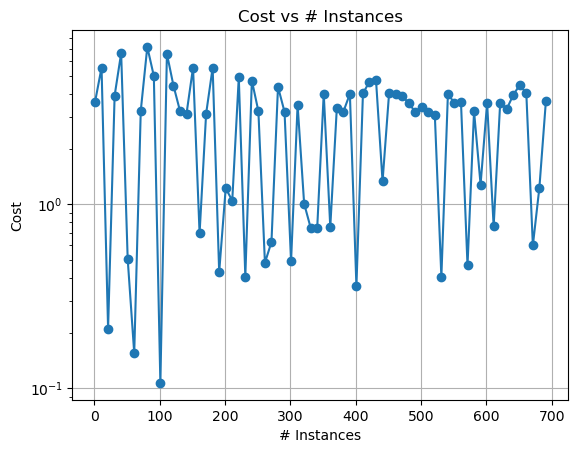

In [22]:

instances = list(out.keys())[::10]
costs = [out[i] for i in instances]

plt.plot(instances, costs, marker='o', linestyle='-')
plt.xlabel('# Instances')
plt.ylabel('Cost')
plt.title('Cost vs # Instances')
plt.grid(True)
plt.yscale('log')  
plt.show()


Step size value of 10